In [8]:
%load_ext autoreload
%load_ext blackcellmagic
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [58]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import glob
import pickle

from nmf_ik.utils import dict_to_nparray_pose, save_file
from nmf_ik.leg_inverse_kinematics import LegInverseKinematics

DATA_PATH = Path(
    "../chuanfang_data"
)

# Next two data come from the paper
pose_data_anipose = pd.read_pickle(
    '../chuanfang_data_anipose/pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh/pose3d.h5'
)

joint_angles_anipose = pd.read_pickle(
    '../chuanfang_data_anipose/pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh/body_joint_angles.pkl'   
)

aligned_pose_pp = pd.read_pickle(
    DATA_PATH / "aligned_pose__180921_aDN_CsCh_Fly6_003_SG1_behData_images_images.pkl"
)

joint_angles_pp = pd.read_pickle(
    DATA_PATH / "paper_joint_angles__180921_aDN_CsCh_Fly6_003_SG1_behData_images_images.pkl"
)

pos_data_df3d = pd.read_pickle(
    DATA_PATH / 'pose_result__180921_aDN_CsCh_Fly6_003_SG1_behData_images_images.pkl'
)['points3d']

ANGLES = [
    "ThC_yaw",
    "ThC_pitch",
    "ThC_roll",
    "CTr_pitch",
    "CTr_roll",
    "FTi_pitch",
    "TiTa_pitch",
]

In [55]:
def rotate_points3d(pts_t):
    tmp = pts_t[:, :, 1].copy()
    pts_t[:, :, 1] = pts_t[:, :, 2].copy()
    pts_t[:, :, 2] = tmp
    pts_t[:, :, 2] *= -1
    pts_t[:, :, 1] *= -1

    return pts_t

pts_convert = rotate_points3d(points_aligned_all)


# Align anipose 

Note that you need to change the inherited class in leg_inverse_kinematics.


In [75]:

nmf_template_chuanfang = {
    "RF_Coxa": np.array([0.416223728, -0.205265575, 1.007183035]),
    "RF_Femur": np.array([0.421337728, -0.212870575, 0.555911035]),
    "RF_Tibia": np.array([0.439128728, -0.294801425, -0.128043705]),
    "RF_Tarsus": np.array([0.439128728, -0.294801425, -0.64642577]),
    "RF_Claw": np.array([0.439128728, -0.294801425, -1.211107601]),
    "LF_Coxa": np.array([0.416223728, 0.205264425, 1.007183035]),
    "LF_Femur": np.array([0.421337728, 0.212869425, 0.555911035]),
    "LF_Tibia": np.array([0.439128728,0.294801425, -0.128043705 ]),
    "LF_Tarsus": np.array([0.439128728, 0.294801425, -0.64642577]),
    "LF_Claw": np.array([0.439128728, 0.294801425, -1.211107601]),
}

nmf_size_chuanfang = {
    "RF_Coxa": np.linalg.norm(nmf_template_chuanfang['RF_Femur'] - nmf_template_chuanfang['RF_Coxa']),
    "RF_Femur": np.linalg.norm(nmf_template_chuanfang['RF_Tibia'] - nmf_template_chuanfang['RF_Femur']),
    "RF_Tibia": np.linalg.norm(nmf_template_chuanfang['RF_Tarsus']  - nmf_template_chuanfang['RF_Tibia']),
    "RF_Tarsus": np.linalg.norm(nmf_template_chuanfang['RF_Claw']  - nmf_template_chuanfang['RF_Tarsus'] ),
    "LF_Coxa": np.linalg.norm(nmf_template_chuanfang['LF_Femur'] - nmf_template_chuanfang['LF_Coxa']),
    "LF_Femur": np.linalg.norm(nmf_template_chuanfang['LF_Tibia'] - nmf_template_chuanfang['LF_Femur']),
    "LF_Tibia": np.linalg.norm(nmf_template_chuanfang['LF_Tarsus'] - nmf_template_chuanfang['LF_Tibia']),
    "LF_Tarsus": np.linalg.norm(nmf_template_chuanfang['LF_Claw'] - nmf_template_chuanfang['LF_Tarsus'] ),
    
}

nmf_offset_chuanfang = {
    "RF_Coxa": nmf_template_chuanfang['RF_Femur'] - nmf_template_chuanfang['RF_Coxa'],
    "RF_Femur": nmf_template_chuanfang['RF_Tibia'] - nmf_template_chuanfang['RF_Femur'],
    "RF_Tibia": nmf_template_chuanfang['RF_Tarsus']  - nmf_template_chuanfang['RF_Tibia'],
    "RF_Tarsus": nmf_template_chuanfang['RF_Claw']  - nmf_template_chuanfang['RF_Tarsus'],
    "LF_Coxa": nmf_template_chuanfang['LF_Femur'] - nmf_template_chuanfang['LF_Coxa'],
    "LF_Femur": nmf_template_chuanfang['LF_Tibia'] - nmf_template_chuanfang['LF_Femur'],
    "LF_Tibia": nmf_template_chuanfang['LF_Tarsus'] - nmf_template_chuanfang['LF_Tibia'],
    "LF_Tarsus": nmf_template_chuanfang['LF_Claw'] - nmf_template_chuanfang['LF_Tarsus'] ,
    
}

In [83]:
from nmf_ik.alignment import AlignPose
from nmf_ik.leg_inverse_kinematics import LegInverseKinematics

align_path = Path('../chuanfang_data_anipose/pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh')

align = AlignPose.from_file_path(
    align_path,
    file_name='pose3d.*',
    pts2align = {
    "RF_leg": [
        "thorax_coxa_R",
        "coxa_femur_R",
        "femur_tibia_R",
        "tibia_tarsus_R",
        "claw_R",
    ],
    "Thorax": ["thorax_wing_R", "thorax_midpoint_tether", "thorax_wing_L"],
    "LF_leg": [
        "thorax_coxa_L",
        "coxa_femur_L",
        "femur_tibia_L",
        "tibia_tarsus_L",
        "claw_L",
    ],
},
    nmf_template = nmf_template_chuanfang,
)
aligned_pos = align.align_pose(export_path=align_path)


# Step 2. calculation of joint angles
# Note that we don't have joint DOF bounds for middle and hind legs
# Let's define something arbitrary for them just for now. 
BOUNDS_NEW = {
    "RF_ThC_roll": (np.deg2rad(-130), np.deg2rad(10)),
    "RF_ThC_yaw": (np.deg2rad(-30), np.deg2rad(60)),
    "RF_ThC_pitch": (np.deg2rad(-60), np.deg2rad(80)),
    "RF_CTr_pitch": (np.deg2rad(-180), np.deg2rad(-20)),
    "RF_CTr_roll": (np.deg2rad(-170), np.deg2rad(20)),
    "RF_FTi_pitch": (np.deg2rad(0), np.deg2rad(170)),
    "RF_TiTa_pitch": (np.deg2rad(-100), np.deg2rad(0)),
    "LF_ThC_roll": (np.deg2rad(-10), np.deg2rad(130)),
    "LF_ThC_yaw": (np.deg2rad(-60), np.deg2rad(30)),
    "LF_ThC_pitch": (np.deg2rad(-80), np.deg2rad(60)),
    "LF_CTr_pitch": (np.deg2rad(-180), np.deg2rad(-20)),
    "LF_CTr_roll": (np.deg2rad(20), np.deg2rad(170)),
    "LF_FTi_pitch": (np.deg2rad(0), np.deg2rad(170)),
    "LF_TiTa_pitch": (np.deg2rad(-100), np.deg2rad(0)),
}


INITIAL_ANGLES_NEW = {
    "RF": {
        "stage_1": np.array([0.0, 0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, -0.32, 0.45, 0.37, -2.14,-2.14, 1.4]),
        "stage_3": np.array([0.0, -0.32, 0.45, 0.37, -2.14,-2.14, -1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.32, 0.45, 0.37, -2.14, -2.14,-1.25, 1.48, 0.0, 0.0]),
    },

    "LF": {
        "stage_1": np.array([0.0, -0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, 0.32, -0.45, 0.37, -2.14,-2.14, 1.4]),
        "stage_3": np.array([0.0, 0.32, -0.45, 0.37, -2.14,-2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, 0.32, -0.45, 0.37, -2.14,-2.14, 1.25, 1.48, 0.0, 0.0]),
    },
}
# Let's run the seq IK.. This will take a while... (~20 mins)

class_seq_ik = LegInverseKinematics(
    aligned_pos=aligned_pos, # our aligned pose
    bounds=BOUNDS_NEW, # bound of joint DOFs
    nmf_size=nmf_offset_chuanfang, # offset in the new config
    initial_angles=INITIAL_ANGLES_NEW, # initial guess for the joint angles (does not matter as long as their in the BOUNDs range)
)

# This will save two separate files: 
# `leg_joint_angles.pkl` -> pickle file that containes the leg joint angles 
# `forward_kinematics.pkl` -> 3D position of the legs construction from the calculated leg joint angles
# The latter is useful for debugging, visualization...
leg_joint_angles, forward_kinematics = class_seq_ik.run_ik_and_fk(export_path=DATA_PATH, femur_orientation=0.1396) # where the results will be saved

2023-05-31 20:29:18,010 - INFO- Scale factor for RF leg: 3.436945912504178
2023-05-31 20:29:18,019 - INFO- Scale factor for LF leg: 3.2596036057212943
2023-05-31 20:29:18,026 - INFO- Aligned pose is saved at ../chuanfang_data_anipose/pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh
2023-05-31 20:29:18,027 - INFO- Calculating joint angles and forward kinematics...
2023-05-31 20:29:52,077 - DEBUG- Stage 1 is completed!
2023-05-31 20:35:52,347 - DEBUG- Stage 2 is completed!
2023-05-31 20:42:29,891 - DEBUG- Stage 3 is completed!
2023-05-31 20:49:12,656 - DEBUG- Stage 4 is completed!
2023-05-31 20:49:47,791 - DEBUG- Stage 1 is completed!
2023-05-31 20:55:29,772 - DEBUG- Stage 2 is completed!
2023-05-31 21:01:39,030 - DEBUG- Stage 3 is completed!
2023-05-31 21:09:09,781 - DEBUG- Stage 4 is completed!
2023-05-31 21:09:09,792 - INFO- Files have been saved at ../chuanfang_data


2023-05-31 20:12:44,573 - DEBUG- Loaded backend module://matplotlib_inline.backend_inline version unknown.


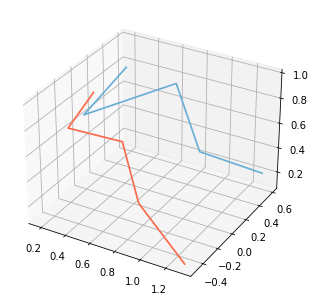

In [74]:
%matplotlib inline
from nmf_ik.visualization import plot_3d_points
import mpl_toolkits.mplot3d.axes3d as p3

fig = plt.figure()
ax3d = p3.Axes3D(fig)


plot_3d_points(ax3d, points_aligned_all, KEY_POINTS_DICT, export_path=None, t=100)

<IPython.core.display.Javascript object>


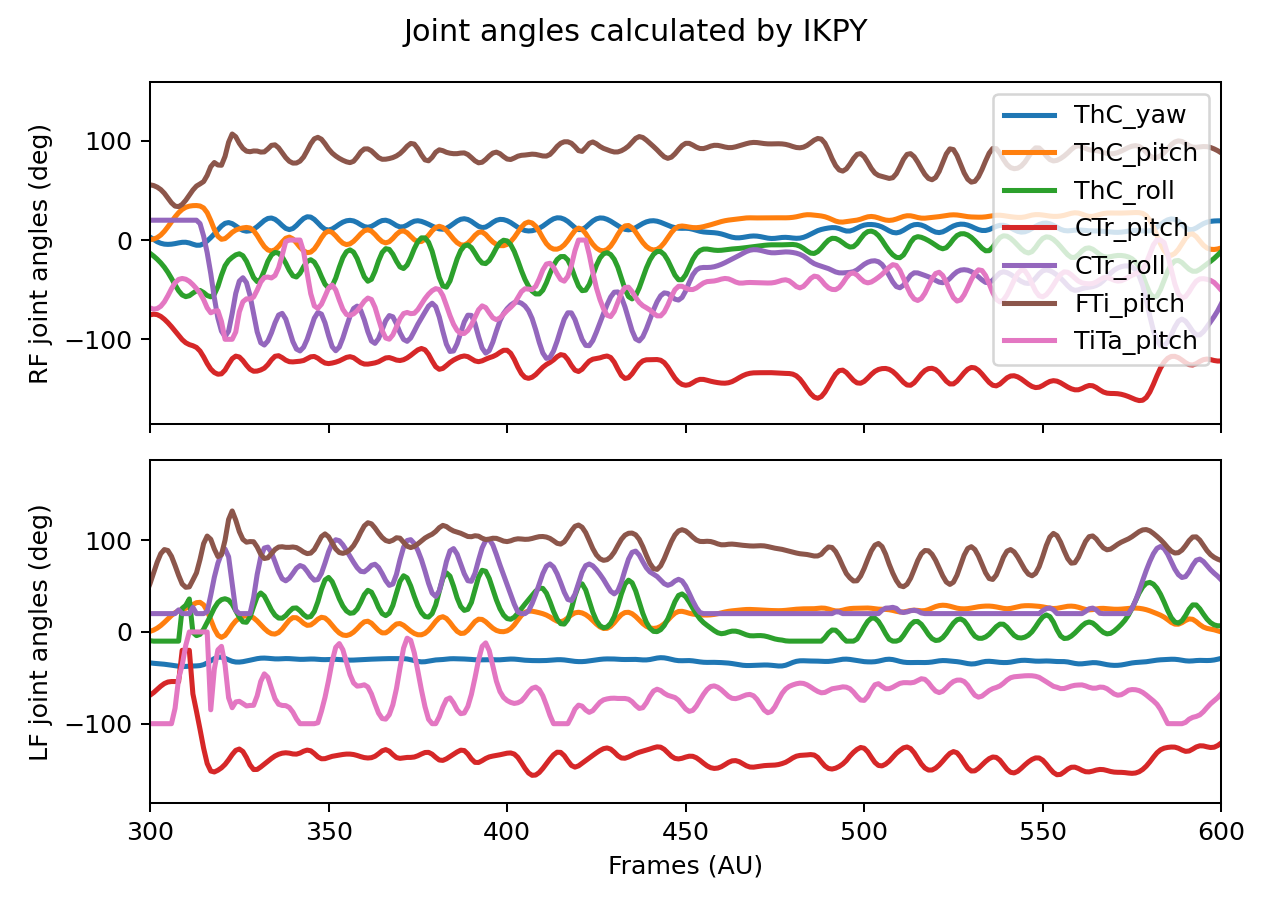

In [121]:
%matplotlib notebook

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

plt.style.use('default')
# Let's plot the joint angles
# Choose a leg

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), dpi=100, sharex=True)


for angle_name in ANGLES:
    ax1.plot(
        np.rad2deg(leg_joint_angles[f"Angle_RF_{angle_name}"]),
        label=angle_name,
        lw=2,
    )
    ax2.plot(
        np.rad2deg(leg_joint_angles[f"Angle_LF_{angle_name}"]),
        lw=2,
    )
    
ax1.set_ylabel("RF joint angles (deg)")
ax2.set_ylabel("LF joint angles (deg)")
# axs[2].set_ylabel("Ant pitch (deg)")
# axs[3].set_ylabel("Ant roll (deg)")

ax2.set_xlabel("Frames (AU)")

ax1.legend()
plt.suptitle(f"Joint angles calculated by IKPY")
plt.xlim(300,600)

plt.tight_layout()

# fig.savefig("../results/alljoints_follow_ikpy_left.png", bbox_inches="tight")

plt.show()

# OLD
## Convert DF3DPP ALIGNED POSE 

In [2]:
# Aligned pose now in a nested dictionary format. -> dictionary[leg_name][key_point_name][raw_pos_aligned]
# My package is using numpy arrays, so we convert the pose dictionary into a compatible format

print(aligned_pose_pp.keys())

converted_aligned_pose = {}

for leg_name, leg_pose_data in aligned_pose_pp.items():
    if 'RF' in leg_name or 'LF' in leg_name:
        converted_aligned_pose[leg_name] = dict_to_nparray_pose(
            leg_pose_data, claw_is_end_effector=True
        )
        
# let's save the new dictionary
save_file(DATA_PATH / 'pose3d_aligned.pkl', converted_aligned_pose)

dict_keys(['RF_leg', 'RM_leg', 'RH_leg', 'LF_leg', 'LM_leg', 'LH_leg'])


# Interpolate, filter

In [15]:
leg_joint_angles.keys()

dict_keys(['Angle_RF_ThC_yaw', 'Angle_RF_ThC_pitch', 'Angle_RF_ThC_roll', 'Angle_RF_CTr_pitch', 'Angle_RF_CTr_roll', 'Angle_RF_FTi_pitch', 'Angle_RF_TiTa_pitch', 'Angle_LF_ThC_yaw', 'Angle_LF_ThC_pitch', 'Angle_LF_ThC_roll', 'Angle_LF_CTr_pitch', 'Angle_LF_CTr_roll', 'Angle_LF_FTi_pitch', 'Angle_LF_TiTa_pitch'])

In [93]:
from scipy.signal import  savgol_filter
from scipy.interpolate import pchip_interpolate


new_leg_joint_angles = {}

frames = leg_joint_angles['Angle_RF_ThC_yaw'].shape[0]
frame_rate = 1e2
scale = 20

time = np.arange(0, frames / frame_rate, 1 / frame_rate)
time_new = np.arange(0, frames / frame_rate, 1 / (scale * frame_rate))

for j_name, j_angles in leg_joint_angles.items():
    
    interpolated_signal = pchip_interpolate(time, j_angles, time_new)
    new_leg_joint_angles[j_name] = savgol_filter(interpolated_signal, polyorder=2, window_length=11, deriv=0)

In [98]:
cropped = {}

for name, ja in new_leg_joint_angles.items():
    cropped[name] = ja[int(3/(5*1e-4)):int(6/(5*1e-4))]

In [100]:
save_file(DATA_PATH_CHUANFANG / 'leg_joint_angles_interpolated.pkl', cropped)

## 2D visualization

Note that for foreleg joint angles, the method is not bad. For middle and hind legs, however, the ThC yaw and pitch are calculated differently. Change matplotlob back-end to notebook using %matplotlib notebook in the beginning of the cell to have an interactive plot, and zoom in ThC yaw and pitch: ***you will see flat lines***.

What does it mean? It means that ***optimization wants to go out of the bonds to satisfy the end effector position however the bounds are too restrictive, which makes sense, given the bounds were originally designed for antennal grooming (a totally different behavior).*** 

What does it mean? It means that you need to do further adjustments to the joint angle bounds for locomotion :)

## 3D visualization

See scripts for more information.

In [ ]:
points_aligned_all.shape

In [25]:
points_fk.shape

(900, 20, 3)

2023-05-17 17:04:44,969 - INFO- Making animation...
2023-05-17 17:05:06,847 - INFO- Animation is saved at ../chuanfang_data/inverse_kinematics_results_side.mp4


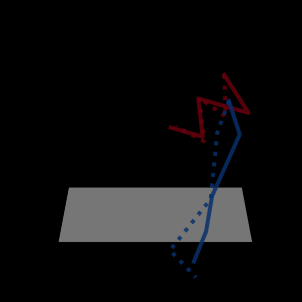

In [12]:
%matplotlib inline 

from nmf_ik.visualization import animate_3d_points
fps = 100

pose3d = DATA_PATH / "pose3d_aligned.pkl"
forward_kinematics = DATA_PATH / "forward_kinematics.pkl"
out_dir = DATA_PATH / f"inverse_kinematics_results_side.mp4"

with open(pose3d, "rb") as f:
    aligned_pose = pickle.load(f)
with open(forward_kinematics, "rb") as f:
    forward_kin = pickle.load(f)

points_aligned_all = np.concatenate(
    (
        aligned_pose["RF_leg"],
        aligned_pose["LF_leg"],
    ),
    axis=1,
)

points_fk = np.concatenate(
    (
        forward_kin["RF_leg"],
        forward_kin["LF_leg"],
    ),
    axis=1,
)

KEY_POINTS_DICT = {
    "RF": (np.arange(0, 5), "solid"),
    "LF": (np.arange(5, 10), "solid"),
}

KEY_POINTS_DICT2 = {
    "RF": (np.arange(0, 10), ":"),
    "LF": (np.arange(10, 20), ":"),
}

animate_3d_points(
    points_aligned_all,
    KEY_POINTS_DICT,
    points3d_second=points_fk,
    key_points_second=KEY_POINTS_DICT2,
    export_path=out_dir,
    frame_no=900,
    elev=15,
    azim=90,
)


In [89]:
points_fk.shape

(6000, 18, 3)

2023-05-31 21:25:24,343 - INFO- Making animation...
2023-05-31 21:26:48,774 - INFO- Animation is saved at ../chuanfang_data_anipose/pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh/inverse_kinematics_results_front.mp4


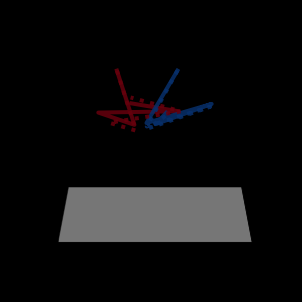

In [107]:
%matplotlib inline 

from nmf_ik.visualization import animate_3d_points
fps = 100

DATA_PATH_CHUANFANG = Path('../chuanfang_data_anipose/pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh')
pose3d = DATA_PATH_CHUANFANG / "pose3d_aligned.pkl"
forward_kinematics = DATA_PATH_CHUANFANG / "forward_kinematics.pkl"
out_dir = DATA_PATH_CHUANFANG / f"inverse_kinematics_results_front.mp4"

with open(pose3d, "rb") as f:
    aligned_pose = pickle.load(f)
with open(forward_kinematics, "rb") as f:
    forward_kin = pickle.load(f)

points_aligned_all = np.concatenate(
    (
        aligned_pose["RF_leg"],
        aligned_pose["LF_leg"],
    ),
    axis=1,
)

points_fk = np.concatenate(
    (
        forward_kin["RF_leg"],
        forward_kin["LF_leg"],
    ),
    axis=1,
)

KEY_POINTS_DICT = {
    "RF": (np.arange(0, 5), "solid"),
    "LF": (np.arange(5, 10), "solid"),
}

KEY_POINTS_DICT2 = {
    "RF": (np.arange(0, 10), ":"),
    "LF": (np.arange(10, 20), ":"),
}

animate_3d_points(
    points_aligned_all,
    KEY_POINTS_DICT,
    points3d_second=points_fk,
    key_points_second=KEY_POINTS_DICT2,
    export_path=out_dir,
    frame_no=3500,
    elev=15,
    azim=0,
)
